# Importando las librerías y funciones básicas

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms


#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal
import qgrid


#Librería de estadística
import scipy as sp

#librería para manejo de fechas
from datetime import datetime,timedelta


# from mpl_toolkits.axes_grid1 import make_axes_locatable

#Análisis Armónico
from ttide import t_tide
from pytides.tide import Tide
# from pytides.astro import astro

plt.style.use("seaborn")
mp.rcParams['font.size'] = 18

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

# Limpieza y exploración de los datos

In [3]:
rutas = np.sort(glob.glob("../Dataset/CMEMS_ECMFW/*.nc"))

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

In [4]:
sla[sla<=-1000]=np.nan

In [ ]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,sla[2000,:,:],20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

In [ ]:
serie=np.nanmean(sla,axis=1)
serie_temp=np.nanmean(serie,axis=1)

In [ ]:
da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
date=pd.DatetimeIndex(da)

In [ ]:
serie_sla=pd.Series(serie_temp,date)

# Graficando un diagrama de Hovmoller

Un diagrama de Hovmoller permite conocer la variación temporal de una variable integrada en las latitudes o en las latitudes.

In [ ]:
new_array = np.array(date.to_pydatetime(), dtype=object)

In [ ]:
sla_copy=sla

Se realiza el filtrado de la información con un suavizado anual para solo captar variaciones interanuales.

In [ ]:
for la in range (sla_copy.shape[1]):
    for lo in range(sla_copy.shape[2]):
        a=sla_copy[:,la,lo]
        serie_test=pd.Series(a,index=date)
        serie_rolling=serie_test.rolling(30).mean()
#         serie_rolling=serie_rolling
        sla_copy[:,la,lo]=serie_rolling.values

## Hovmoller con las longitudes

In [ ]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(lon,new_array)
cf=ax2.contourf(x,y,sla_copy[:,27,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy[:,27,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[-1],new_array[365]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon.png',dpi=600,bbox_inches="tight")

### Interpolando los datos a resoluciones espaciales menores.

In [ ]:
new_lon=np.arange(240,286,1)
sla_copy_mod=np.zeros((sla_copy.shape[0],len(new_lon)))
for i in range(sla_copy.shape[0]):
    sla_copy_mod[i,:]=np.interp(new_lon,lon,sla_copy[i,27,:])

In [ ]:
sla_copy_mod.shape

In [ ]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[0],lon[-1]],[lat[27],lat[27]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[2300],new_array[1400]))

ax2.tick_params(labelsize=15)
plt.savefig('./Plots/hovmoller_lon_mod.png',dpi=600,bbox_inches="tight")

**La pregunta de investigación que surgiría es: ¿Los incrementos de nivel del mar en Buenaventura (tasas altas) se han registrado antes en una mayor longitud (mar adentro)?**

## Hovmoller con las latitudes

In [ ]:
fig=plt.figure(figsize=(10,13))

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6],hspace=0.2)

x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
                 u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
                 u'80\N{DEGREE SIGN}W']

y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
                 u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
                 u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax1.set_extent([lon[0], lon[-1], lat[0],lat[-1]], ccrs.PlateCarree())
ax1.coastlines('50m')
ax1.add_feature(cartopy.feature.LAND, zorder=0,facecolor='#B1B2B4')
ax1.plot([lon[150],lon[150]],[lat[0],lat[-1]],color='red',transform=ccrs.PlateCarree())

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--',
                   xlocs=xlocs,ylocs=ylocs)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 13, 'color': 'black'}
gl.ylabel_style = {'size': 13, 'color': 'black'}

# plt.title('CMEMS Reanalysis',y=1.3, loc='right',fontsize=18)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_title('Diagrama de Hovmoller para lon: '+str(360-lon[150])+"°W",fontsize=18)

x,y=np.meshgrid(new_array,lat)
cf=ax2.contourf(x,y,sla[:,:,150].T,10,cmap="jet")
cr=ax2.contour(x,y,sla[:,:,150].T,10,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

# ax2.set_xticks(np.array(xlocs)+360)
# ax2.set_xticklabels(x_tick_labels)
ax2.set_xlim((new_array[365],new_array[-1]))

ax2.tick_params(labelsize=15)

Revisando el diagrama de Hovmoller para las longitudes puede intuirse que si existe una zona más hacia el oeste donde también ocurren las altas tasas de nivel medio del mar que se registran en Buenaventura.

Para comparar las tasas de nivel medio del mar de 2016-2019 (zona con mayores incrementos) con otros períodos, se calculan las tasas de cambio en ventanas de 3 años

# Recopilando la información y análisis de 2019

In [85]:
fecha_inicio=datetime(1970,1,1)
fecha_inicio2=datetime(1988,1,1)
# fecha_fin=datetime(2019,1,1)
fecha_fin2=datetime(1986,1,1)

## Cargue de información de nivel del mar

In [5]:
df_nmm=pd.read_csv(r"../Dataset/rqh0085a.csv")
fechas=[datetime(df_nmm.Year.loc[i],df_nmm.Month.loc[i],df_nmm.Day.loc[i],df_nmm.Hour.loc[i]) for i in range(len(df_nmm))]
serie_nmm=pd.Series(data=df_nmm.nmm.values/1000,index=fechas)
# serie_nmm=serie_nmm[fecha_inicio:]

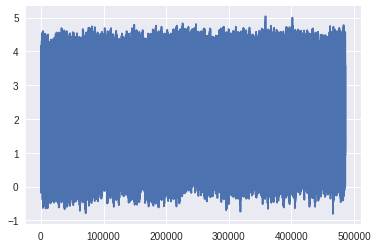

In [6]:
plt.plot(serie_nmm.values)

## Calculando el porcentaje de datos faltantes por año:

In [7]:
data_nmm=pd.DataFrame(serie_nmm,columns=["nmm"])
data_nmm["year"]=data_nmm.index.year
data_nmm_year=data_nmm.groupby("year").count()

In [8]:
porcentajes=np.zeros((int(len(data_nmm_year.index)),1))
for i,z in enumerate(data_nmm_year.index):
    d=(lambda year : (year % 400 == 0) or (year % 4 == 0 and year % 100 != 0))(z)
    if d==True:
        dv=366*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100
    else:
        dv=365*24
        porcentajes[i]=((dv-data_nmm_year.nmm[z])/(dv))*100

In [ ]:
df_faltantes=pd.DataFrame(porcentajes,index=data_nmm_year.index,columns=["Datos faltantes [%]"])

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(serie_nmm)
plt.title("Serie de nivel del mar")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

plt.show()

In [4]:
serie_real=serie_nmm-np.mean(serie_nmm)

## Determinación de la marea astronómica

In [40]:
# marea = niveles-nmm
# tide = Tide.decompose(marea, tiempos)
# tide1 = Tide(model = tide.model, radians = False)
# astronomica = tide1.at(tiempos)
# meteo = marea-tide1.at(tiempos)

In [5]:
tide = Tide.decompose(serie_real.values,serie_real.index)

In [6]:
tide1 = Tide(model = tide.model, radians = False)

In [7]:
astronomica = tide1.at(serie_real.index)
serie_astronomica=pd.Series(astronomica,index=serie_real.index)

In [9]:
serie_astronomica.to_csv("astronomica_buenaventura.csv")

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [95]:
serie_residual=serie_real-serie_astronomica

<IPython.core.display.Javascript object>


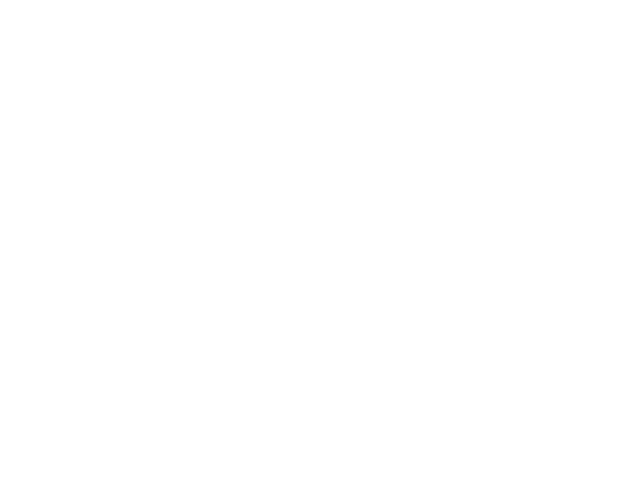

(array([711858., 715510., 719163., 722815., 726468., 730120., 733773.,
        737425.]), <a list of 8 Text xticklabel objects>)

In [96]:
plt.figure()
plt.plot(serie_residual)
plt.xticks(rotation=30)


In [75]:
a=datetime(1975,10,5)
b=datetime(1975,10,21)

<IPython.core.display.Javascript object>


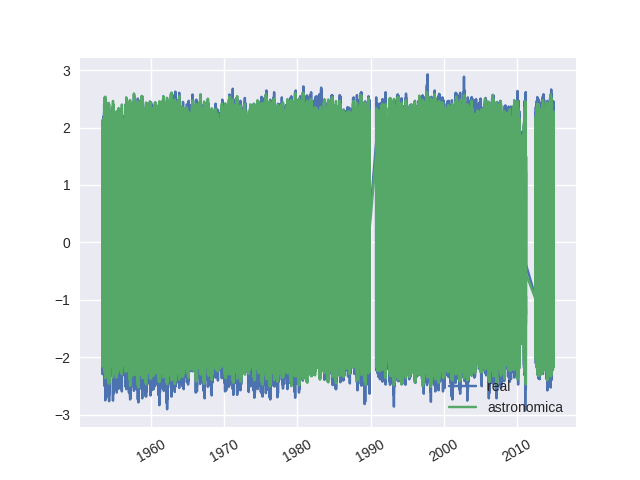

In [97]:
%matplotlib notebook
plt.figure()
plt.plot(serie_real,label="real")
plt.plot(serie_astronomica,label="astronomica")
plt.xticks(rotation=30)
plt.legend()

In [ ]:
plt.plot()

In [58]:
constituent = [c.name for c in tide.model['constituent']]
df = pd.DataFrame(tide.model, index=constituent).drop('constituent', axis=1)
df.sort_values('amplitude', ascending=False).head(10)
print('Form number %s, the tide is %s.' %
      (tide.form_number()[0], tide.classify()))

Form number 0.07404437171080588, the tide is semidiurnal.


In [59]:
df

,amplitude,phase
Z0,8.818746e-16,180.000000
M2,1.496180e+00,254.876106
S2,4.020873e-01,314.505943
N2,3.143344e-01,225.782371
K1,1.148958e-01,62.672819
M4,6.526875e-02,222.617288
O1,2.566022e-02,72.832462
M6,1.904818e-03,47.834515
MK3,4.724058e-03,30.646567
S4,8.254021e-03,10.961457


In [ ]:
serie_real[fecha_inicio2:fecha_fin2]

In [ ]:
def astronomica(serie_real):
    ttide=t_tide(serie_real,dt=1)
    ttide_out=ttide
    datos_astro=ttide_out["xout"].ravel()
    serie_astro=pd.Series(data=datos_astro,index=serie_real.index)
    return serie_astro

serie_astro=astronomica(serie_real[fecha_inicio2:fecha_fin2])

Según información recolectada, el mayor aporte a la marea lo da la componente $M_{2}$ (principal lunar), por lo tanto es semidiurno (**tiene todo el sentido del mundo**)

Aportes principales:

- $M_{2}$: Principal lunar, 150.09 cm
- $S_{2}$: Principal solar, 40.25 cm
- $N_{2}$: Lunar mayor elíptica, 31.66 cm
- $K_{2}$: Lunar-solar declinacional, 10.97 cm
- $K_{1}$: Lunar-solar diurna declinacional, 11.25 cm


EL link de la info es [Caracterización de la marea](http://www.ideam.gov.co/documents/21021/23877/Caracterizaci%C3%B3n+de+la+Marea+%282010%29.pdf/a8ed71d8-3d7f-4a88-bed5-796c542aff4f)


In [ ]:
plt.plot(serie_astro)

## Sensibilidad de la componente M2 respecto a la cantidad de información tomada

In [2]:
fecha_inicio=datetime(1993,1,1)
amps_m2=np.ones((15,1))

for i in range(0,15,1):
    ttide=t_tide(serie_real[fecha_inicio:datetime(1993+i+1,1,1)],dt=1)
    ttide_out=ttide
    idx_m2=np.where(ttide_out["nameu"]==b'M2  ')[0]
    amps=ttide_out["tidecon"][:,0]
    amp_m2=amps[idx_m2]
    amps_m2[i]=amp_m2

NameError: name 'serie_real' is not defined

In [ ]:
plt.plot(np.arange(1,16,1),amps_m2)

## Recreando la serie completa desde ttide

In [3]:
ttide=t_tide(serie_real[fecha_inicio2:fecha_fin2],dt=1,out_style=None)
ttide_out=ttide

freqs=ttide_out["fu"]
amps=ttide_out["tidecon"][:,0]
phases=ttide_out["tidecon"][:,2]
amps_err=ttide_out["tidecon"][:,1]

suma_total=np.zeros((len(serie_real[fecha_inicio2:fecha_fin2]),))*1j
t=np.arange(0,len(serie_real[fecha_inicio2:fecha_fin2]))
for ix in range(0,len(freqs)):
    suma_total+=(amps[ix]+amps_err[ix])*np.exp(1j*(freqs[ix]*2*np.pi*t+phases[ix]))
#     suma_total+=amplitud*(np.cos(nmm_freq[ix]*2*np.pi*t+fase)+1j*np.sin(nmm_freq[ix]*2*np.pi*t+fase))


NameError: name 'serie_real' is not defined

In [ ]:
plt.plot(suma_total[:100])

In [ ]:
datos_astro=ttide_out["xout"].ravel()
plt.plot(datos_astro[:100])

## Suavizado de la información

Con el fin de que la visualización de la información sea más clara y ordenada, se realiza un suavizado de cada 30 horas.

In [4]:
def smooth(y,box_pts):
    box=np.ones(box_pts)/box_pts
    y_smooth=np.convolve(y,box,mode="same")
    return y_smooth

In [5]:
def maximos(serie_real,inicio):
    maximos_real,fechas_real=[],[]
#     maximos_astro,fechas_astro=[],[]
    for k in range(int(len(serie_real)/24)):

        #Ventana de marea real
        window_real=serie_real[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        max_window_real=np.max(window_real)

        #Ventana de marea astronómica
#         window_astro=serie_astro[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
#         max_window_astro=np.max(window_astro)

        if max_window_real>0:
#             maximos_astro.append(max_window_astro)
#             fechas_astro.append(window_astro.idxmax()-timedelta(hours=window_astro.idxmax().hour))    
            maximos_real.append(max_window_real)
            fechas_real.append(window_real.idxmax()-timedelta(hours=window_real.idxmax().hour))

    #Series de máximos
    serie_maximos_real=pd.Series(data=maximos_real,index=fechas_real)
#     serie_maximos_astro=pd.Series(data=maximos_astro,index=fechas_astro)
    return serie_maximos_real

serie_max_real=maximos(serie_real,fecha_inicio)

NameError: name 'serie_real' is not defined

In [ ]:
def smoothed(serie_max_real):
    serie_dif_maximos=serie_max_real
    dif_maximos_smoothed=smooth(serie_dif_maximos,30)
    serie_maximos_smoothed=pd.Series(data=dif_maximos_smoothed,index=serie_dif_maximos.index)
    return serie_dif_maximos,serie_maximos_smoothed

In [ ]:
serie_dif_maximos,serie_maximos_smoothed=smoothed(serie_max_real)

In [ ]:
plt.figure(figsize=(10,6))
plt.title("Serie de Máximos")
plt.plot(serie_dif_maximos,c="orange",alpha=0.5)
plt.plot(serie_maximos_smoothed,c="k")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

## Datos y Eventos ENSO desde el índice ONI

In [1]:
dataset_oni=pd.read_excel(r"../Dataset/oni index.xlsx").set_index("Year")
# rutas = glob.glob("../Dataset/CMEMS_ECMFW/*.nc")

NameError: name 'pd' is not defined

In [ ]:
def serie_oni(dataset_oni):
    data=dataset_oni.values.ravel()
    fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_oni_d=pd.Series(data=data,index=date)[fecha_inicio:]
    return serie_oni_d

In [ ]:
Serie_oni=serie_oni(dataset_oni)

In [ ]:
def looking_for_events(Serie_oni):
    loc_niña=[] #Revisar siempre estas posiciones
    loc_niño=[]
    for i in range (4,int(len(Serie_oni)-4)):
        k,d,z=0,0,0
        while k<5:
            a=i+k-4
            b=i+k+1
            window=np.around(np.asarray((Serie_oni.values[a:b])),1)
            test_niño=window>=0.5
            test_niña=window<=-0.5
            if test_niño.all()==True:
                d=d+1
            if test_niña.all()==True:
                z=z+1
            k=k+1
        if d>=1:
            loc_niño.append(i)
        if z>=1:
            loc_niña.append(i)
    return loc_niña,loc_niño

In [6]:
locs_niña,locs_niño=looking_for_events(Serie_oni)     

NameError: name 'looking_for_events' is not defined

In [ ]:
def events(loc_niño,loc_niña):
    fines_niña=np.where(np.diff(loc_niña)!=1)[0].tolist()+[len(loc_niña)-1]
    fines_niño=np.where(np.diff(loc_niño)!=1)[0].tolist()+[len(loc_niño)-1]
    inicios_niña=[0]+[i+1 for i in fines_niña][:-1]
    inicios_niño=[0]+[i+1 for i in fines_niño][:-1]
    return inicios_niño,fines_niño,inicios_niña,fines_niña

In [ ]:
inicio_niño,fin_niño,inicio_niña,fin_niña=events(locs_niño,locs_niña)

In [ ]:
def plotting_events(Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
    fig,ax=plt.subplots(1,1,figsize=(12,6))
    ax.plot(Serie_oni,'-o',c='k')
    ax.set_title("Eventos ENSO")
    ax.set_yticks(np.arange(-3,3,0.5))
    ax.grid()
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    plt.grid()
    plt.savefig(".\Plots\Eventos_ENSO.png",dpi=400,box_inches="tight")
    return fig

In [ ]:
plots_ENSO=plotting_events(Serie_oni,inicio_niño[1:],fin_niño[1:],locs_niño,inicio_niña,fin_niña,locs_niña)

## Traslapando la información

In [7]:
def converge(serie_original,serie_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
        fig,ax=plt.subplots(1,1,figsize=(12,6))
#         ax.plot(serie_oni,c='red',alpha=0.5)
        ax.plot(serie_original,c='orange',alpha=0.5)
        ax.set_title("Serie de nmm vs Eventos ENSO [ONI]")
        ax.plot(serie_smoothed,c='k')
        ax.set_yticks(np.arange(-3,3,0.5))
        ax.set_ylim(0,3)
        ax.grid()
        ax.set_ylabel("h [m]")
        ax.set_xlabel("Tiempo [h]")
        for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
        for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
        plt.savefig(".\Plots\All.png",dpi=400,box_inches="tight")
        return fig

In [8]:
plt.plot(serie_maximos_smoothed)

NameError: name 'serie_maximos_smoothed' is not defined

In [ ]:
plot_final=converge(serie_dif_maximos,serie_maximos_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña)

# Análisis espectral

In [ ]:
plt.figure()
plt.plot(serie_real)

In [ ]:
fecha_inicio2,fecha_fin2

In [ ]:
def T_fourier(serie):
    serie_trend=serie[fecha_inicio2:fecha_fin2].values
    serie_detrened=signal.detrend(serie_trend)
    fourier=np.fft.fft(serie_detrened)
    freq= np.fft.fftfreq(len(serie_detrened)) 
    pot = np.abs(fourier*1./len(fourier))
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

In [ ]:
nmm_fourier,nmm_freq_pos,nmm_potencias,nmm_periodos,nmm_freq,=T_fourier(serie_real)

In [ ]:
# %matplotlib notebook
plt.figure(figsize=(8,4))
plt.suptitle("Espectro de potencias de Fourier")
plt.subplot(121)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k')
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$m^{2}$]")
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplot(122)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$m^{2}$]")
plt.xlim(0,30)
plt.ylim(0,0.1)
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplots_adjust(wspace=0.3)

In [ ]:
df_fourier=pd.DataFrame({"potencias":nmm_potencias[nmm_freq_pos],"p":nmm_periodos[nmm_freq_pos]})

In [ ]:
# df_fourier[(round(df_fourier["p"],2)==11.96) | (round(df_fourier["p"],2)==11.97)]

In [ ]:
test=df_fourier.sort_values(by="potencias")
# qgrid_widget = qgrid.show_grid(test, show_toolbar=True)

## Construyendo una componente

Para una primera aproximación, se intentará recrear el armónico $S_{2}$

In [9]:
index=np.where(round(df_fourier["p"],2)==11.97)[0][2] #Index 4384 con mayor potencia
amplitud_s2=nmm_potencias[index]*2 
fase_s2=np.angle(nmm_fourier[index])

NameError: name 'df_fourier' is not defined

In [ ]:
t=np.arange(0,len(nmm_fourier))
s2_e=amplitud_s2*np.exp(1j*(nmm_freq[index]*2*np.pi*t+fase_s2))
s2=amplitud_s2*(np.cos(nmm_freq[index]*2*np.pi*t+fase_s2)+1j*np.sin(nmm_freq[index]*2*np.pi*t+fase_s2))

In [ ]:
plt.plot(s2[:49])
plt.plot(s2_e[:49])

In [ ]:
n=len(nmm_fourier)

nmm_fourier_copy=np.copy(nmm_fourier)    
np.put(nmm_fourier_copy, range(0,index), 0.0)
np.put(nmm_fourier_copy, range(index+1, n), 0.0)
nmm_fourier_copy=nmm_fourier_copy*2
# Now fourier holds 1 imaginary coefficient
ifft = np.fft.ifft(nmm_fourier_copy)

In [ ]:
plt.plot(ifft[:49])
plt.plot(s2[:49])

## Construyendo diversas componentes

In [10]:
index=test[test.p<=3].index

NameError: name 'test' is not defined

In [ ]:
test.p[index]

### Obteniendo la sumatoria de las componente armónicas

In [11]:
suma_total=np.zeros((len(nmm_fourier),))*1j
t=np.arange(0,len(nmm_fourier))
for ix in index:
    amplitud=nmm_potencias[ix]*2 
    fase=np.angle(nmm_fourier[ix])
    suma_total+=amplitud*np.exp(1j*(nmm_freq[ix]*2*np.pi*t+fase))
#     suma_total+=amplitud*(np.cos(nmm_freq[ix]*2*np.pi*t+fase)+1j*np.sin(nmm_freq[ix]*2*np.pi*t+fase))

NameError: name 'nmm_fourier' is not defined

In [ ]:
plt.figure()
plt.plot(suma_total)

In [12]:
n=len(nmm_fourier)
suma=np.zeros((len(nmm_fourier),))*1j
for i in index:
    nmm_fourier_copy=np.copy(nmm_fourier)    
    np.put(nmm_fourier_copy, range(0,i), 0.0)
    np.put(nmm_fourier_copy, range(i+1, n), 0.0)
# Now fourier holds 1 imaginary coefficient
    ifft = np.fft.ifft(nmm_fourier_copy*2)
    suma+=ifft

NameError: name 'nmm_fourier' is not defined

In [ ]:
plt.figure()
plt.plot(suma)

Sólo queda elegir los períodos a través de los cuales se quiere filtrar, extender el vector t dentro del ciclo y restar el valor obtenido al registro inicial.

In [13]:
serie_real=serie_real.rolling(30).mean()

NameError: name 'serie_real' is not defined

In [ ]:
serie_real

In [ ]:
plt.plot(serie_real)

# Revisando evento por evento

## Niño 1994-1995 (moderado)

NameError: name 'lat' is not defined

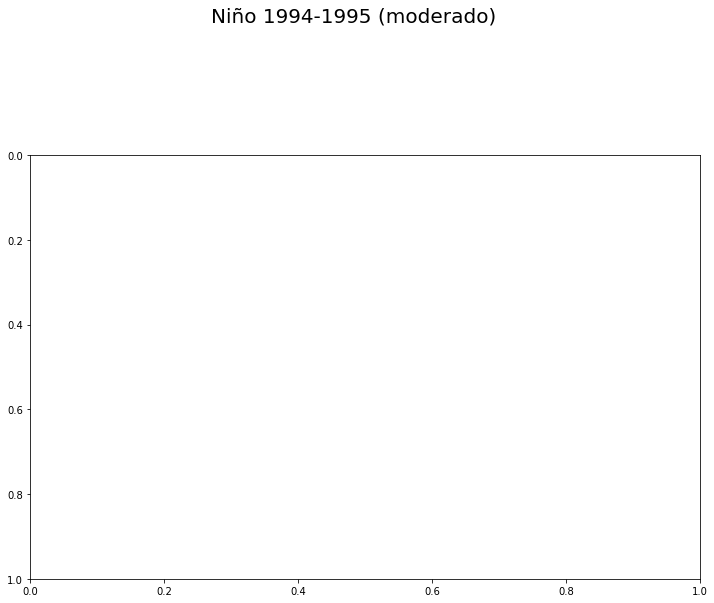

In [14]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 1994-1995 (moderado)",y=0.92,fontsize=20)

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*3],new_array[0]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)


#Linea alrededor de 92°W
ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(serie_real, 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[0],new_array[365*3]))

plt.savefig('./Plots/hovmoller_95_96.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 12 cm, su intensidad fue moderada, empezó en Septiembre y acabó en marzo y duró cerca de 6 meses.

Las anomalías que registra son...

## Niño 1997-1998 (very strong) 

In [ ]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 1997-1998 (muy fuerte)",y=0.92,fontsize=20)


gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*6],new_array[365*3]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)

ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)


# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*3],new_array[365*6]))

plt.savefig('./Plots/hovmoller_97_98.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 30 cm, su intensidad fue muy fuerte, empezó en Mayo y acabó en Abril y duró cerca de 11 meses.

Las anomalías que registra son...

## Niño 2002-2003 (moderate)

In [ ]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2002-2003 (moderado)",y=0.92,fontsize=20)
gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*11],new_array[365*9]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)

ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)


# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*9],new_array[365*11]))

plt.savefig('./Plots/hovmoller_02_03.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 18 cm, su intensidad fue moderada, empezó en Junio y acabó en Febrero y duró cerca de 7 meses.

Las anomalías que registra son...

## Niño 2004-2005 (weak)

NameError: name 'lat' is not defined

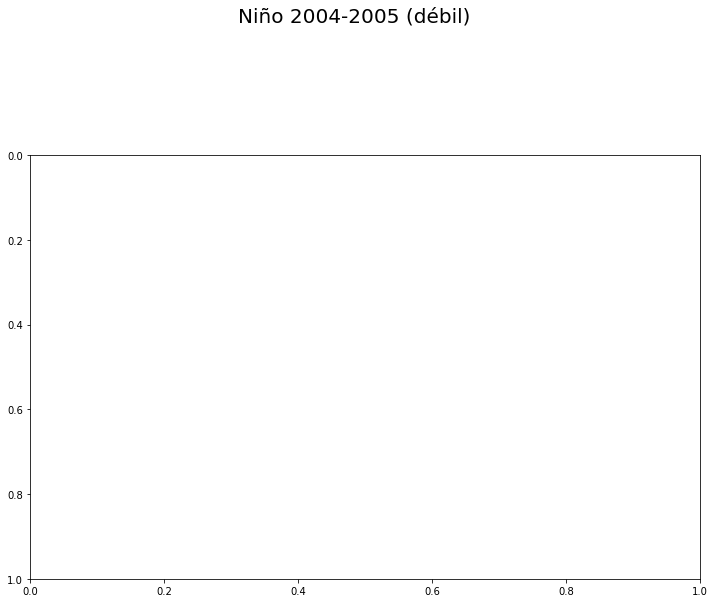

In [15]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2004-2005 (débil)",y=0.92,fontsize=20)
gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*13],new_array[365*10]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)

ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*10],new_array[365*13]))

plt.savefig('./Plots/hovmoller_04_05.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 10-11 cm, su intensidad fue débil, empezó en Julio y acabó en Febrero y duró cerca de 6 meses.

Las anomalías que registra son...

## Niño 2006-2007 (weak)

In [ ]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2006-2007 (débil)",y=0.92,fontsize=20)

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*15],new_array[365*13]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)
ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)


# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*13],new_array[365*15]))

plt.savefig('./Plots/hovmoller_06_07.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 10-11 cm, su intensidad fue débil, empezó en Julio y acabó en Febrero y duró cerca de 4 meses.

Las anomalías que registra son...

In [16]:
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    a=Serie_oni.index[locs_niño[i]]
    b=Serie_oni.index[locs_niño[k]]
    print(a,b)

NameError: name 'inicio_niño' is not defined

## Niño 2009-2010 (moderate)

NameError: name 'lat' is not defined

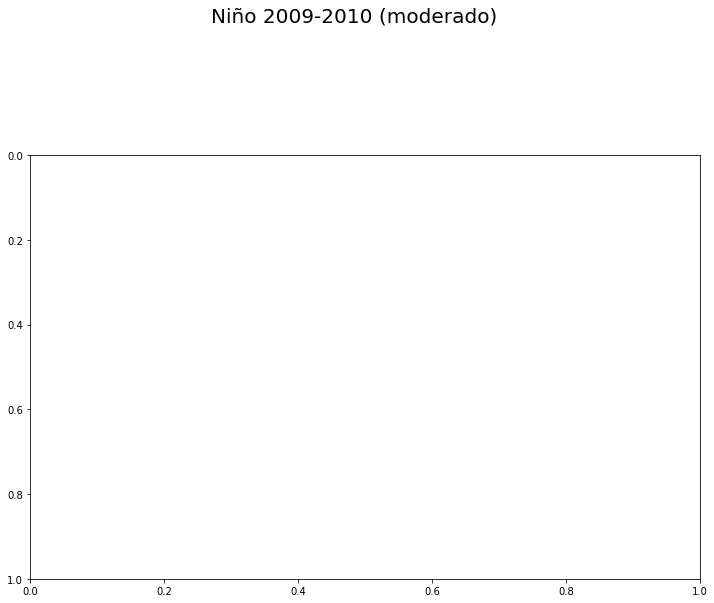

In [17]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2009-2010 (moderado)",y=0.92,fontsize=20)

gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*18],new_array[365*16]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)
ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)


# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*16],new_array[365*18]))

plt.savefig('./Plots/hovmoller_09_10.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 21-23 cm, su intensidad fue moderada, empezó en Julio y acabó en Febrero y duró cerca de 8 meses.

Las anomalías que registra son...

## Niño 2014-2015 (weak)

In [ ]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2014-2015 (débil)",y=0.92,fontsize=20)
gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*23],new_array[365*21]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)
ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)

# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*21],new_array[365*23]))

plt.savefig('./Plots/hovmoller_14_15.png',dpi=600,bbox_inches="tight")

## Niño 2015-2016 (Very strong)

NameError: name 'lat' is not defined

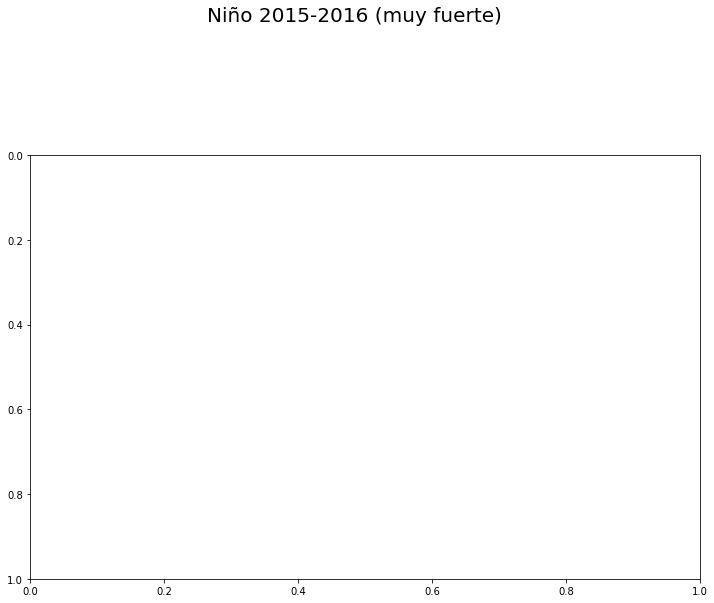

In [18]:
fig=plt.figure(figsize=(12,10))
fig.suptitle("Niño 2015-2016 (muy fuerte)",y=0.92,fontsize=20)
gs = gsa.GridSpec(nrows=2, ncols=1,height_ratios=[1,6])

# x_tick_labels = [u'120\N{DEGREE SIGN}W', u'110\N{DEGREE SIGN}W',
#                  u'100\N{DEGREE SIGN}W', u'90\N{DEGREE SIGN}W',
#                  u'80\N{DEGREE SIGN}W']

# y_tick_labels = [u'-2\N{DEGREE SIGN}N', u'0\N{DEGREE SIGN}N',
#                  u'2\N{DEGREE SIGN}N', u'4\N{DEGREE SIGN}N',
#                  u'6\N{DEGREE SIGN}N',u'8\N{DEGREE SIGN}N']

xlocs=np.arange(-120, -60, 10)
ylocs=np.arange(-3,10,2)

# Acerca del segundo subplot
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
ax2.set_title('Diagrama de Hovmoller para lat: '+str(lat[27])+"°N",fontsize=18)

x,y=np.meshgrid(new_lon,new_array)
cf=ax2.contourf(x,y,sla_copy_mod[:,:],20,cmap="jet")
cr=ax2.contour(x,y,sla_copy_mod[:,:],20,colors="k",linewidths=0.3)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.08, aspect=50)
cbar.set_label('m',fontsize=15)
cbar.ax.tick_params(labelsize=15) 

ax2.set_xticks(np.array(xlocs)+360)
ax2.set_xticklabels(x_tick_labels)
ax2.set_ylim((new_array[365*24],new_array[365*22]))
ax2.set_xlim((new_lon[0],new_lon[-4]))

ax2.tick_params(labelsize=15)
ax2.axvline(x=new_lon[26],c='k',ls='--',lw=3)


# Acerca del primer subplot
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(pd.Series(smooth(serie_real,90),index=serie_real.index), 'k')
for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
    ax1.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
ax1.set_ylabel("nmm [m]")
ax1.set_xlim((new_array[365*22],new_array[365*24]))

plt.savefig('./Plots/hovmoller_15_16.png',dpi=600,bbox_inches="tight")

Tuvo cerca a la costa, anomalías alrededor de los 30 cm, su intensidad fue muy fuerte, empezó en Julio y acabó en Febrero y duró cerca de 8-9 meses.

Las anomalías que registra son...

In [ ]:
rutas = glob.glob("../Dataset/CMEMS_ECMFW/*.nc")